### Edgar Moises Hernandez-Gonzalez
#### 21/02/20-25/02/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 62.15%
##### Kappa = 0.4954

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = 52.08%
##### Kappa = 0.3611

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 60.42%
##### Kappa = 0.4722

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = 55.21%
##### Kappa = 0.4028

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 63.19%
##### Kappa = 0.5093

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = 51.74%
##### Kappa = 0.3565

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM, GRU, ConvLSTM2D,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((288,528,4))
  temporal = np.zeros((528,4))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[j*24:(j+1)*24, :] = Sxx[8:32, :]
    datos[i] = temporal
  return datos

In [0]:
#unir 2 canales C3 y C4
'''
def espectrogramas(data):
  fs = 250
  datos = np.zeros((288,24,8))
  for i in range(data.shape[0]): #288 muestras
    sig = data.iloc[i, 7000:8000]
    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
    C3 = Sxx[8:32, :]
    sig = data.iloc[i, 11000:12000]
    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
    C4 = Sxx[8:32, :]
    datos[i] = np.concatenate((C3, C4), axis=1)
  return datos
'''

'\ndef espectrogramas(data):\n  fs = 250\n  datos = np.zeros((288,24,8))\n  for i in range(data.shape[0]): #288 muestras\n    sig = data.iloc[i, 7000:8000]\n    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n    C3 = Sxx[8:32, :]\n    sig = data.iloc[i, 11000:12000]\n    f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT\n    C4 = Sxx[8:32, :]\n    datos[i] = np.concatenate((C3, C4), axis=1)\n  return datos\n'

In [0]:
#llamar a unir_espectrogramas_vertical(data, fs)
x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 528, 4)
(288, 528, 4)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

127.36705810165053
103.14882408038861
3.3899630126531786e-07
5.741129212423684e-07


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99505514
0.8058502
2.6484086e-09
4.485257e-09


In [0]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 528, 4, 1)
(288, 1, 528, 4, 1)


In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
288/288 - 0s - loss: 1.1570 - acc: 0.4826
kappa:  0.31018518518518523
f1: 0.4685103354737468
confusion matrix:
 [[21 37 11  3]
 [ 9 53  9  1]
 [ 6 10 39 17]
 [ 5  6 35 26]]


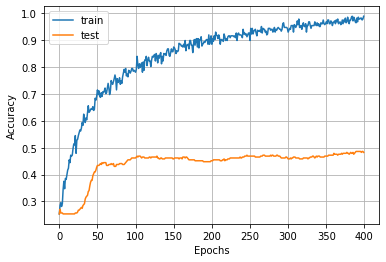

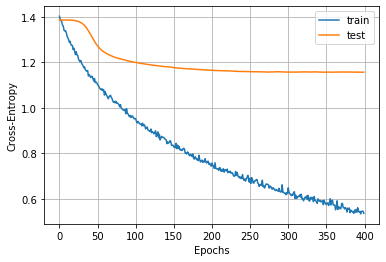

Iteration: 2
288/288 - 0s - loss: 1.1667 - acc: 0.5174
kappa:  0.3564814814814815
f1: 0.5199489083203923
confusion matrix:
 [[37 15 15  5]
 [20 36 10  6]
 [ 3  5 40 24]
 [ 6  1 29 36]]


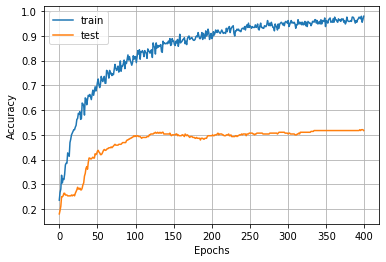

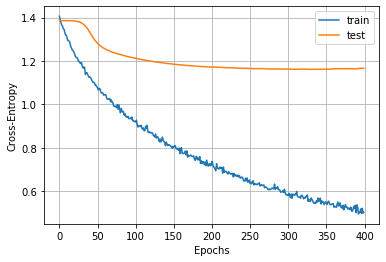


Resultados:
loss: [1.1570396953158908, 1.16667373975118]
accuracy: [0.4826389, 0.5173611]
kappa: [0.31018518518518523, 0.3564814814814815]
f1: [0.4685103354737468, 0.5199489083203923]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_35 (ConvLSTM2D) (None, 528, 4, 32)        38144     
_________________________________________________________________
batch_normalization_40 (Batc (None, 528, 4, 32)        128       
_________________________________________________________________
activation_34 (Activation)   (None, 528, 4, 32)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 67584)             0         
_________________________________________________________________
dense_76 (Dense)             (None, 16)                1081360   
_________________________________________________________________
batch_normalization_41 (Batc (None, 16)                64        
_________________________________________________________________
activation_35 (Activation)   (None, 16)              

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5000
std: (+/- 0.0174)
Mean Kappa: 0.3333
std: (+/- 0.0231)
Mean F1: 0.4942
Max Accuracy: 0.5174
Max Kappa: 0.3565
Max F1: 0.5199
